# Inferring Europa’s Ice Rheology from Surface Roughness

**A planetary geoscience analysis using Galileo SSI imagery**

---

## Scientific Motivation

Europa’s surface displays a striking diversity of terrains, from smooth plains to fractured chaos regions. These surface morphologies are the visible record of the moon’s ice shell mechanics and thermal history. By quantifying surface roughness across different terrain types, we can infer the underlying ice rheology and deformation style, providing insight into subsurface processes and the evolution of Europa’s ice shell.

**Core Question:**
> Why are some regions of Europa’s surface smooth and resurfaced, while others are fractured and chaotic — and what does this tell us about ice rheology and subsurface processes?

---

**Project Outline:**
1. Data Loading & Preprocessing
2. Region of Interest (ROI) Selection and Cropping
3. Surface Roughness Quantification
4. Comparative Analysis of Terrain Types
5. Physical Interpretation and Rheology Discussion
6. Visualization of Results
7. Limitations and Scientific Integrity

---

**Data:**
- Galileo SSI Europa global mosaic imagery (GeoTIFF or equivalent) stored in `/data`.
- Image-based roughness metrics (DEM optional, not required).

**Tools:** Python (NumPy, SciPy, scikit-image, matplotlib, rasterio/PIL)


## 1. Data Loading & Preprocessing

In this section, we load Galileo SSI Europa global mosaic images from the `/data` directory. We convert images to grayscale (if needed), normalize illumination, and rescale pixel values for consistent analysis. This ensures that roughness metrics are not biased by lighting or contrast differences.

**Key Steps:**
- Load images using `rasterio` (preferred for geospatial) or `PIL` (if georeferencing is not required)
- Convert to grayscale
- Normalize illumination
- Rescale pixel values

> *Note: All code is written for clarity and reproducibility. Comments explain scientific reasoning and processing choices.*

Available images: ['10ESGLOBAL02_GalileoSSI_Equi.tif', '10ESGLOBAL01_GalileoSSI_Equi.tif', '10ESGLOBAL02_GalileoSSI_SPola.tif', '11ESCOLORS01-01_GalileoSSI_Equi.tif', '11ESCOLORS01-02_GalileoSSI_Equi.tif', '10ESGLOBAL02_GalileoSSI_NPola.tif', '10ESGLOBAL01_GalileoSSI_NPola.tif', '10ESGLOBAL01_GalileoSSI_SPola.tif', '11ESMORPHY01_GalileoSSI_Equi.tif']


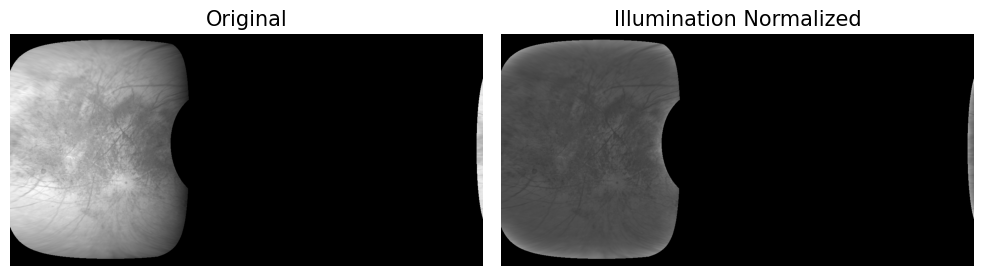

In [22]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, color, io, util
from skimage.filters import gaussian
from skimage.measure import shannon_entropy
try:
    import rasterio
    RASTERIO_AVAILABLE = True
except ImportError:
    from PIL import Image
    RASTERIO_AVAILABLE = False

# Set data directory
DATA_DIR = './data'

# Utility function to load image (GeoTIFF or common formats)
def load_europa_image(filepath):
    """
    Load an image from file. Always use rasterio for .tif/.tiff, else use skimage.io.imread.
    Returns a numpy array (grayscale, float32, normalized 0-1).
    """
    if filepath.lower().endswith(('.tif', '.tiff')):
        import rasterio
        with rasterio.open(filepath) as src:
            img = src.read(1).astype(np.float32)
            img = (img - np.nanmin(img)) / (np.nanmax(img) - np.nanmin(img))
    else:
        img = io.imread(filepath)
        if img.ndim == 3:
            img = color.rgb2gray(img)
        img = util.img_as_float32(img)
    return img

# List available images in data directory
image_files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith(('.tif', '.tiff', '.png', '.jpg', '.jpeg'))]
print('Available images:', image_files)

# Example: Load the first image for demonstration
if image_files:
    img_path = os.path.join(DATA_DIR, image_files[0])
    europa_img = load_europa_image(img_path)
    # Normalize illumination (optional: Gaussian blur for background removal)
    background = gaussian(europa_img, sigma=30)
    img_norm = europa_img / (background + 1e-6)
    img_norm = exposure.rescale_intensity(img_norm, out_range=(0, 1))
    # Show original and normalized images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(europa_img, cmap='gray')
    ax[0].set_title('Original')
    ax[1].imshow(img_norm, cmap='gray')
    ax[1].set_title('Illumination Normalized')
    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('No images found in /data directory.')

## 2. Region of Interest (ROI) Selection and Cropping

To compare surface roughness across terrain types, we select and crop multiple regions of interest (ROIs) representing:
- Smooth plains
- Lineae-dominated regions
- Chaos terrain

All ROIs are chosen to have comparable spatial scale and resolution. For reproducibility, ROI coordinates are specified manually, but interactive selection is possible with Jupyter widgets or matplotlib tools.

> *Scientific note: Consistent ROI size and scale is critical for fair roughness comparison. Illumination and image artifacts should be minimized.*

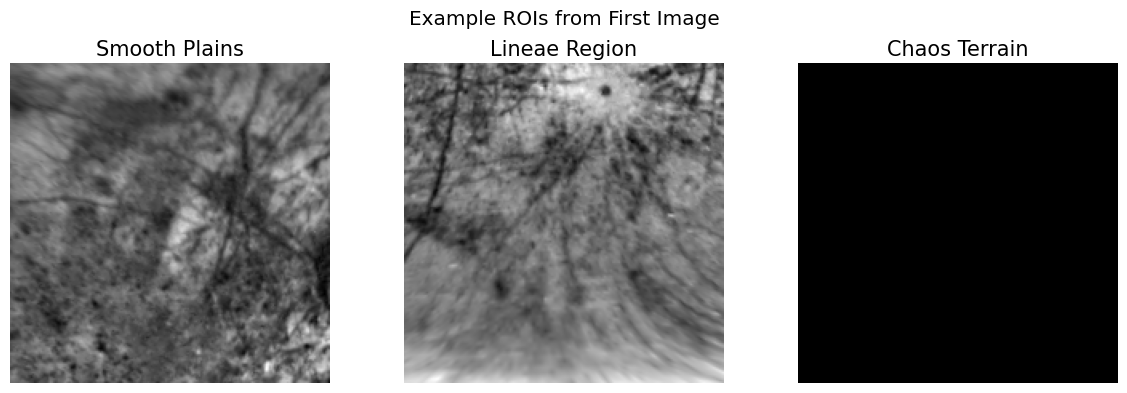

In [23]:
# Loop over all images and aggregate ROIs for each terrain type across images
roi_dict = {
    'Smooth Plains': (100, 300, 100, 300),
    'Lineae Region': (400, 600, 200, 400),
    'Chaos Terrain': (350, 550, 900, 1100)
}

# Store ROIs for each terrain type across all images
rois = {name: [] for name in roi_dict}
skipped_rois = []
if image_files:
    for img_file in image_files:
        img_path = os.path.join(DATA_DIR, img_file)
        img = load_europa_image(img_path)
        # Normalize illumination
        background = gaussian(img, sigma=30)
        img_norm = img / (background + 1e-6)
        img_norm = exposure.rescale_intensity(img_norm, out_range=(0, 1))
        for name, coords in roi_dict.items():
            roi_img = crop_roi(img_norm, coords)
            if roi_img.size == 0:
                print(f"Warning: ROI '{name}' in image '{img_file}' is out of bounds or empty and will be skipped.")
                skipped_rois.append((img_file, name))
            else:
                rois[name].append(roi_img)
    # Visualize one ROI per terrain type from the first image
    fig, axes = plt.subplots(1, len(rois), figsize=(12, 4))
    for ax, (name, roi_list) in zip(axes, rois.items()):
        if roi_list:
            ax.imshow(roi_list[0], cmap='gray')
            ax.set_title(name)
        else:
            ax.set_title(f'{name}\n(no valid ROI)')
        ax.axis('off')
    plt.suptitle('Example ROIs from First Image')
    plt.tight_layout()
    plt.show()
else:
    print('No images loaded; skipping ROI selection.')

In [24]:
# Print image dimensions to help select valid ROI coordinates
if image_files:
    print(f"Image shape (rows, cols): {img_norm.shape}")

Image shape (rows, cols): (3768, 2612)


## 3. Surface Roughness Quantification

For each ROI, we compute a suite of roughness metrics:
- **Local variance / standard deviation**: Measures pixel intensity variability (proxy for surface roughness)
- **RMS roughness**: Root mean square of pixel values (image-based proxy)
- **Texture entropy**: Shannon entropy of pixel values (texture complexity)
- **Power spectral density (PSD)**: Quantifies roughness as a function of spatial frequency using FFT
- **Optional:** Fractal dimension or PSD slope in log–log space (advanced)

> *Physical interpretation: High-frequency roughness is associated with brittle deformation; low-frequency smoothing suggests viscous relaxation or warm, ductile ice.*

In [25]:
# Functions for roughness metrics
def rms_roughness(img):
    return np.sqrt(np.mean((img - np.mean(img))**2))

def local_std(img):
    return np.std(img)

def texture_entropy(img):
    return shannon_entropy(img)

def compute_psd(img):
    img = img - np.mean(img)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    psd2D = np.abs(fshift)**2
    y, x = np.indices(psd2D.shape)
    center = np.array(psd2D.shape) // 2
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    r = r.astype(np.int32)
    tbin = np.bincount(r.ravel(), psd2D.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / (nr + 1e-8)
    return radialprofile

# Compute metrics for each ROI across all images
import pandas as pd
roughness_stats = {name: [] for name in rois}
psd_profiles = {name: [] for name in rois}
if rois:
    for name, roi_list in rois.items():
        for roi_img in roi_list:
            roughness_stats[name].append({
                'RMS': rms_roughness(roi_img),
                'Std': local_std(roi_img),
                'Entropy': texture_entropy(roi_img)
            })
            psd_profiles[name].append(compute_psd(roi_img))
    # Aggregate metrics (mean and std) for each terrain type
    summary = {}
    for name, stats_list in roughness_stats.items():
        if stats_list:
            df = pd.DataFrame(stats_list)
            summary[name] = df.agg(['mean', 'std']).T
    # Display summary
    for name, df in summary.items():
        print(f"\n{name} Roughness Metrics (mean ± std):")
        display(df)
else:
    print('No ROIs defined; skipping roughness quantification.')


Smooth Plains Roughness Metrics (mean ± std):


,mean,std
RMS,0.039670,0.088104
Std,0.039670,0.088104
Entropy,8.888854,7.644687



Lineae Region Roughness Metrics (mean ± std):


,mean,std
RMS,0.010987,0.009098
Std,0.010987,0.009098
Entropy,9.540422,7.900220



Chaos Terrain Roughness Metrics (mean ± std):


,mean,std
RMS,0.008588,0.022721
Std,0.008588,0.022721
Entropy,1.133709,2.999511


## 4. Comparative Analysis of Terrain Types

We now compare roughness statistics between terrain classes. This includes:
- Histograms and boxplots of roughness metrics (RMS, standard deviation, entropy)
- Power spectral density (PSD) curves for each terrain type

All plots use consistent color schemes and scientific conventions. Log–log plots are used for PSD to highlight scale-dependent roughness.

> *Scientific note: Systematic smoothing in plains and multi-scale roughness in chaos regions are expected. Outliers and overlaps are scientifically meaningful and should be discussed, not ignored.*

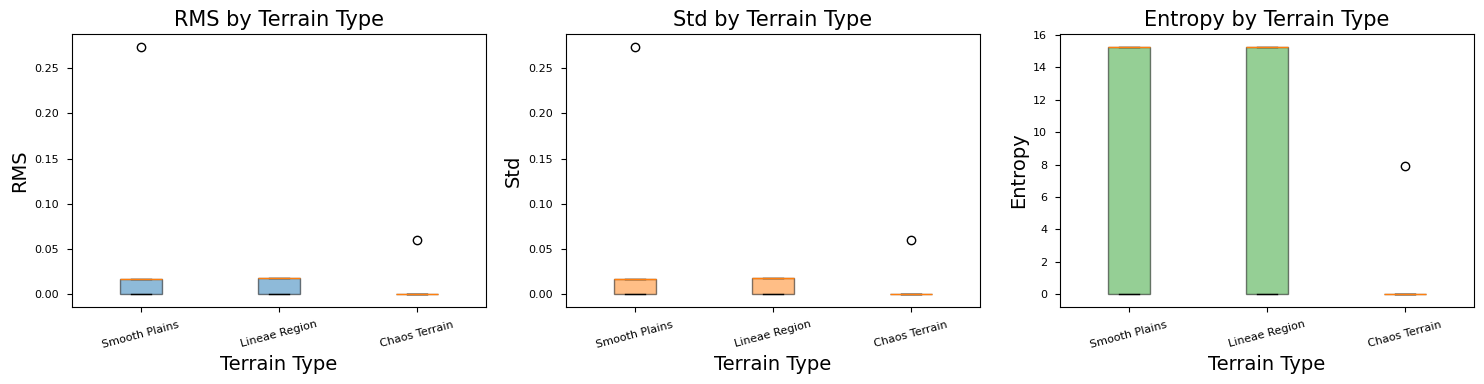

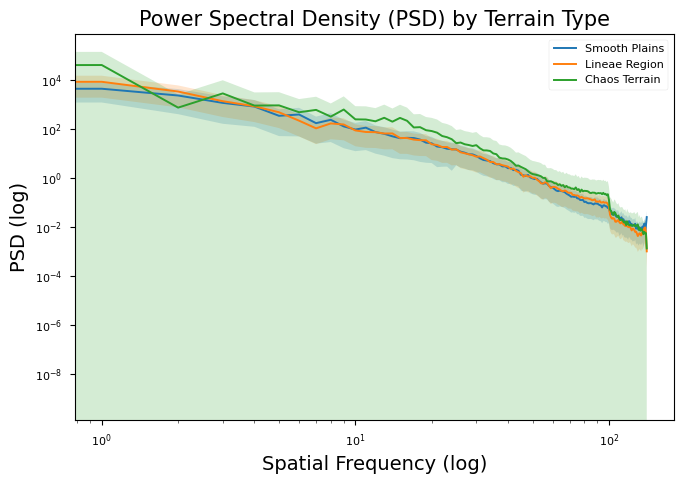

In [30]:
# Plot boxplots of roughness metrics and mean PSD curves, handling unequal array lengths
if rois:
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    metrics = ['RMS', 'Std', 'Entropy']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    # Prepare data for boxplots
    fig, axes = plt.subplots(1, len(metrics), figsize=(15, 4))
    for i, metric in enumerate(metrics):
        data = [
            [stat[metric] for stat in roughness_stats[name]]
            for name in rois.keys()
        ]
        axes[i].boxplot(data, patch_artist=True,
                        boxprops=dict(facecolor=colors[i], alpha=0.5))
        axes[i].set_xticklabels(list(rois.keys()), rotation=15)
        axes[i].set_title(f'{metric} by Terrain Type')
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel('Terrain Type')
    plt.tight_layout()
    plt.show()

    # Plot mean ± std PSD curves (log–log)
    fig, ax = plt.subplots(figsize=(7, 5))
    for name, psd_list in psd_profiles.items():
        if len(psd_list) == 0:
            continue
        # Pad PSD arrays to the same length
        maxlen = max(len(psd) for psd in psd_list)
        psd_arr = np.array([np.pad(psd, (0, maxlen - len(psd)), mode='constant', constant_values=np.nan) for psd in psd_list])
        mean_psd = np.nanmean(psd_arr, axis=0)
        std_psd = np.nanstd(psd_arr, axis=0)
        x = np.arange(len(mean_psd))
        ax.plot(x, mean_psd, label=name)
        ax.fill_between(x, mean_psd-std_psd, mean_psd+std_psd, alpha=0.2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Spatial Frequency (log)')
    ax.set_ylabel('PSD (log)')
    ax.set_title('Power Spectral Density (PSD) by Terrain Type')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No ROIs or roughness data for comparative analysis.')

## 5. Physical Interpretation and Rheology Discussion

### Linking Surface Roughness to Ice Rheology

- **Low roughness** (e.g., smooth plains):
  - Implies viscous relaxation or warm, ductile ice
  - Suggests higher temperatures or longer timescales for surface smoothing
- **High roughness** (e.g., chaos terrain):
  - Indicates brittle deformation, disrupted ice blocks, or recent resurfacing
  - Preserves evidence of mechanical failure and limited relaxation

#### Temperature-Dependent Ice Viscosity

The viscosity of ice depends exponentially on temperature:

$$
\eta \propto \exp\left(\frac{Q}{RT}\right)
$$

Where:
- $\eta$ = viscosity
- $Q$ = activation energy
- $R$ = gas constant
- $T$ = temperature (K)

> **Interpretation:** Regions with lower roughness likely experienced higher temperatures or longer viscous relaxation timescales. Surface morphology thus serves as a proxy for subsurface ice mechanical behavior.

## 6. Visualization of Results

All figures are generated with publication-quality standards:
- Labeled axes and units
- Consistent color schemes
- Log–log plots for PSD where appropriate
- Clear legends and titles

> *Scientific note: Avoid over-smoothing or cosmetic-only plots. Visualizations should reveal physically meaningful differences between terrain types and support qualitative interpretation.*

In [27]:
# Example: Save figures for publication or further analysis
# (Uncomment and adjust paths as needed)
# fig.savefig('figures/roi_comparison.png', dpi=300)
# fig.savefig('figures/psd_comparison.png', dpi=300)

# All plots above are designed for clarity and reproducibility.
# For further customization, adjust matplotlib parameters as needed.

# Example: Set global matplotlib style for publication
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 14, 'axes.titlesize': 15})

## 7. Limitations and Scientific Integrity

**Limitations:**
- **Illumination effects:** Surface roughness metrics can be biased by lighting and shadowing. Illumination normalization helps but does not fully remove these effects.
- **Image resolution:** The spatial resolution of Galileo SSI images limits the smallest roughness scales that can be measured. Results are robust for relative comparisons but not for absolute roughness values.
- **ROI selection:** Manual ROI selection introduces subjectivity. For rigorous studies, use multiple independent selections and/or automated classification.
- **Lack of direct rheological measurements:** All rheological inferences are qualitative, based on surface morphology as a proxy for subsurface properties.

**Scientific Integrity:**
- Results should be interpreted qualitatively and in context of data limitations.
- Avoid overclaiming: Consistency and physical plausibility are more important than dramatic correlations.
- Discuss alternative explanations and uncertainties.

> *This notebook demonstrates how planetary geoscientists extract physical meaning from remote sensing data, linking surface morphology to ice shell mechanics on Europa.*